## Tutorial 4: Canonical Forms
In this tutorial we shall build upon and extend some of the ideas introduced in Tutorial 3, including how to properly compose multiple tensor decompositions as well as more sophisticated means to fix the gauge degrees of freedom, leading to the notion of a **canonical form** for tensor networks. Here, as with the previous tutorial, we shall also only consider tensor networks that do not possess closed loops (i.e. instances of tree tensor networks). Topics include: 

- Multi-stage tensor decompositions

- Centers of orthogonality on tensor links 

- Canonical forms of tensor networks


## T4.1: Multi-stage tensor decompositions


We begin by addressing an important problem: given a many-index tensor $H$, how can we accurately decompose this into a network $T$ of tensors {$A$, $B$, $C$ …} according to some prescribed geometry, for instance, as depicted in Fig.4.1(a)? More precisely, we would like to find choice of tensors {$A$, $B$, $C$ …} that minimizes the difference ‖$H - T$‖ from the original tensor, given some fixed dimension χ of the internal indices in $T$. 
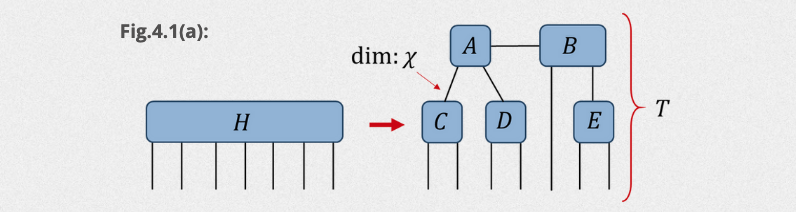


In order to obtain the network approximation to a tensor we shall employ a **multi-stage decomposition**: a sequence of single tensor decompositions via the SVD. This is the opposite procedure to the contraction routine considered in Tutorial 1, where a network of multiple tensors was contracted to a single tensor via a sequence of binary tensor contractions. The results from Tutorial 3, in particular Corollary 3.4, already inform us of the correct way to perform a multi-stage decomposition: **the tensor to be decomposed at each step should be a center of orthogonality**, which will ensure that the global truncation error is minimized.



Fig.4.1(b) below illustrates a sequence of single tensor decompositions that take a single tensor $H_0$ into the network $T$ of Fig.4.1(a). At each step a tensor $H_k$ is split using a truncated SVD (retaining the desired rank χ) into a product of three tensors {$U_k$, $S_k$, $V_k$} across the partition indicated by the dashed line, where we have colored isometric tensors orange. The matrix of singular $S_k$ values is then absorbed into the tensor that is to be decomposed at the next step (indicated by the dashed ellipse), such that it becomes a center of orthogonality, since all other tensors in the network are isometric. This process is repeated until the desired network geometry is reached. Ex.4.1(b) gives an example of code that can implement the multi-stage decomposition as depicted, given some initial tensor $H_0$ and desired rank χ, and then checks the accuracy of the decomposition.

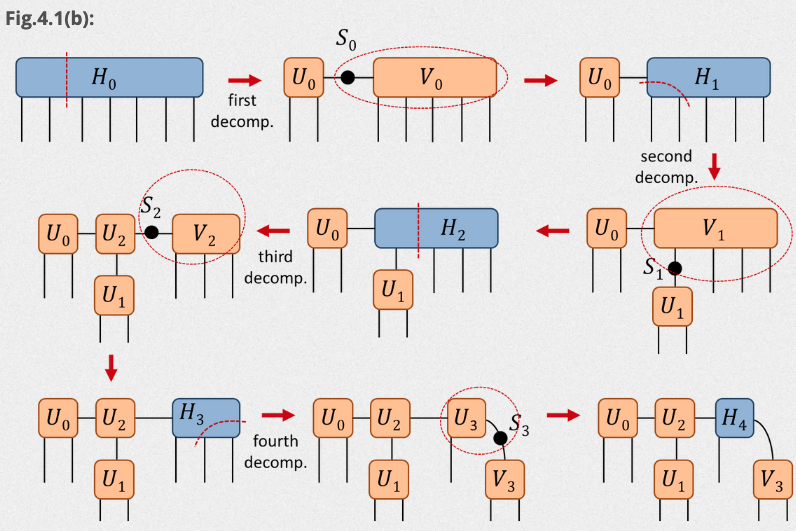

In [2]:
import numpy as np
from numpy import linalg as LA
from ncon import ncon
##### Ex4.1(b): multi-stage decomposition
d = 5 # local dimension
chi = 3 # max internal dimension 
H0 = (np.sqrt(1+np.arange(d**7))).reshape(d,d,d,d,d,d,d).transpose(6,5,4,3,2,1,0) 

# first decomposition
utemp,stemp,vhtemp = LA.svd(H0.reshape(d**2,d**5),full_matrices=False)
U0 = (utemp[:,:chi]).reshape(d,d,chi)
H1 = (np.diag(stemp[:chi]) @ vhtemp[:chi,:]).reshape(chi,d,d,d,d,d)
# second decomposition
utemp,stemp,vhtemp = LA.svd(H1.transpose(1,2,0,3,4,5).reshape(d**2,chi*d**3),full_matrices=False)
U1 = (utemp[:,:chi]).reshape(d,d,chi)
H2 = (np.diag(stemp[:chi]) @ vhtemp[:chi,:]).reshape(chi,chi,d,d,d).transpose(1,0,2,3,4)
# third decomposition
utemp,stemp,vhtemp = LA.svd(H2.reshape(chi**2,d**3),full_matrices=False)
U2 = (utemp[:,:chi]).reshape(chi,chi,chi)
H3 = (np.diag(stemp[:chi]) @ vhtemp[:chi,:]).reshape(chi,d,d,d)
# fourth decomposition
utemp,stemp,vhtemp = LA.svd(H3.reshape(chi*d,d**2),full_matrices=False)
V3 = vhtemp[:chi,:].reshape(chi,d,d).transpose(1,2,0)
H4 = (utemp[:,:chi] @ np.diag(stemp[:chi])).reshape(chi,d,chi)
# check result
H0recovered = ncon([U0,U1,U2,V3,H4],[[-1,-2,1],[-3,-4,2],[1,2,3],[-6,-7,4],[3,-5,4]])
totErr = LA.norm(H0 - H0recovered) / LA.norm(H0)

print("Total truncation error at χ=3 : ", totErr)

Total truncation error at χ=3 :  6.381973359135298e-05


**Notes on multi-stage decompositions:**

- Similar to the freedom to choose a sequence of binary contractions when contracting a tensor network, one has freedom in choosing the sequence of decompositions in a multi-stage decomposition. If the decompositions include index truncations then some sequences could be computationally cheaper than others.

- In the example of Fig.4.1(b), the desired center of orthogonality was created at each step by simply absorbing the singular weights correctly into the new desired center. In general this may be more difficult; some decomposition sequences may require use the gauge changing methods from Tutorial 3 to create the desired center of orthogonality at each intermediate step.

- When following the outlined procedure for multi-stage decompositions the truncation error at each individual decomposition step is minimized. However, the cumulative error from the sequence of decompositions is not guaranteed to be minimal, and may indeed change depending on the particular sequence of decompositions used. However, in practice this effect is usually negligible: differences in the cumulative error are small in comparison to the cumulative error itself.


## T4.2: Center of orthogonality (link centered)


In Tutorial 3, the concept as fixing a tensor within a network to become a center of orthogonality was introduced. Here we consider an extension to this idea, where we fix an internal index (or link) within a network as a center of orthogonality.

 

The idea is very simple: one can introduce a new link matrix σ situated on the link in question, which is initially defined as the identity matrix and thus does not change any property of the network, and then proceed using one of the previous methods to fix σ as a center of orthogonality. This is illustrated below in Fig.4.2(a), where the <u>'direct orthogonalization'</u> approach is used to set the B-C link as a center of orthogonality within a network of three tensors {$A$, $B$, $C$}.
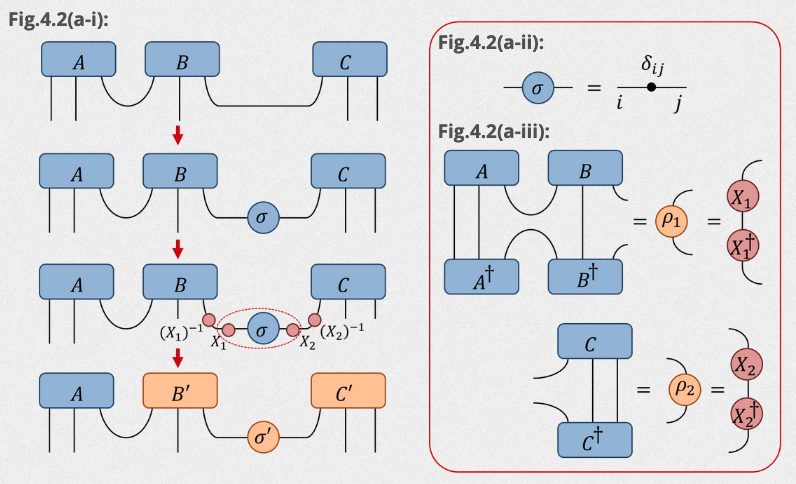


In [4]:
##### Ex4.2(a): set B-C link as center of orthogonality
d = 5 # index dimension
A = np.random.rand(d,d,d)
B = np.random.rand(d,d,d)
C = np.random.rand(d,d,d)
Sig = np.eye(d); # initial link matrix

# generate gauge change matrices
rho1 = ncon([A,A,B,B],[[1,2,3],[1,2,4],[3,5,-1],[4,5,-2]])
rho2 = ncon([C,C],[[-1,1,2],[-2,1,2]])
d1, u1 = LA.eigh(rho1); sq_d1 = np.sqrt(abs(d1))
d2, u2 = LA.eigh(rho2); sq_d2 = np.sqrt(abs(d2))
X1 = u1 @ np.diag(sq_d1) @ u1.T; X1inv = u1 @ np.diag(1/sq_d1) @ u1.T
X2 = u2 @ np.diag(sq_d2) @ u2.T; X2inv = u2 @ np.diag(1/sq_d2) @ u2.T

# implement gauge change
Bprime = ncon([B,X1inv],[[-1,-2,1],[1,-3]])
Cprime = ncon([X2inv,C],[[-1,1],[1,-2,-3]])
Sig_prime = X1 @ Sig @ X2

# check result
H0 = ncon([A,B,C],[[-1,-2,1],[1,-3,2],[2,-4,-5]])
H1 = ncon([A,Bprime,Sig_prime,Cprime],[[-1,-2,1],[1,-3,2],[2,3],[3,-4,-5]])
totErr = LA.norm(H0 - H1) / LA.norm(H0) 

print("Truncation error : ", totErr)

Truncation error :  1.2696964454719628e-15


In the example depicted in Fig.4.2(a), the link matrix σ' satisfies the definition of a center of orthogonality established in <u>**Def.3.3**</u>. However, for the link-centered case we shall impose also an additional constraint: that **the gauge should be chosen such that the final form of link matrix should be diagonal, with positive elements in descending order of magnitude**. Achieving this requires a final step over the previous orthogonalization approaches, where one should take the SVD of the link matrix σ' and then make a unitary change of gauge such that it is bought into diagonal form. Fig.4.2(b) illustrates this procedure below, continuing on from the example in Fig.4.2(a), such that the final link matrix σ" is diagonal with positive elements in ascending order 
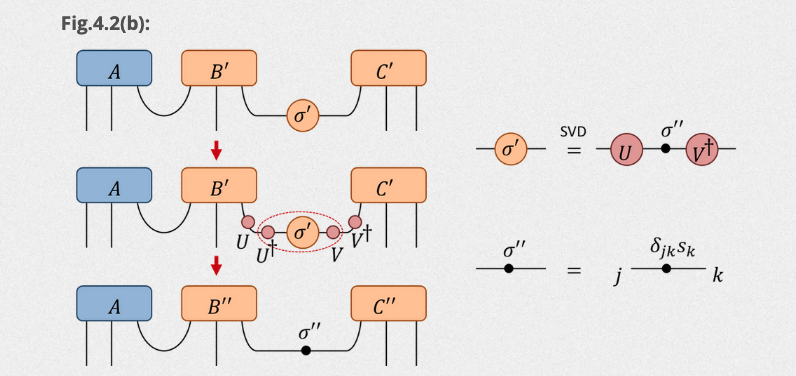



In [6]:
##### Ex4.2(b): setting a link as a center of orthogonality
##### (continues from Ex4.2(a))

# perform unitary gauge change to diagonalize link matrix
utemp, Sig_pp, vhtemp = LA.svd(Sig_prime,full_matrices=False)
Bpp = ncon([Bprime,utemp],[[-1,-2,1],[1,-3]])
Cpp = ncon([Cprime,vhtemp],[[1,-2,-3],[-1,1]])
# check result
H2 = ncon([A,Bpp,np.diag(Sig_pp),Cpp],[[-1,-2,1],[1,-3,2],[2,3],[3,-4,-5]])
totErr = LA.norm(H0 - H2) / LA.norm(H0) 

print("Truncation error : ", totErr)

Truncation error :  1.220945228174951e-15


**Equivalence of the (link) center of orthogonality and the SVD:**


Given a network of tensors {$A$, $B$, $C$, $D$ ...} that contracts to a single tensor $H$, the form of the network produced from fixing a link as the center of orthogonality is related to an SVD of the tensor $H$, as we now explain.


Let us continue with example from Fig.4.2(b) for clarity. We define tensor $H$ as the result of contracting the original network and assume the SVD produces $H = U_H \cdot S_H \cdot (V_H)^\dagger$, as depicted in Fig.4.2(c). However, the network produced in Fig.4.2(b) from setting tensor σ" as a center of orthogonality is understood as equivalent to an SVD given (i) the grouping of network to the left of the center (tensor $A$ with $B''$ in this case) forms an isometry, (ii) matrix σ" is diagonal with positive elements in ascending order and (iii) the network to the right of the center (tensor $C^{"}$ in this case) is also an isometry.


Assuming that the singular values are non-degenerate, the SVD is known to be unique up to the signs of the singular vectors (or phases of the singular vectors for complex matrices). Thus, we conclude that $U_H = (A⋅ B^{"})$ and $(V_H)^\dagger = C^{"}$, up to the possibility of plus/minus signs, while the link matrix σ" precisely equals the matrix of singular values $S_H$, as depicted in Fig.4.2(c). Here we have also assumed that the tensors {$U_H$, $S_H$, $V_H$} were initially trimmed to remove any trivial singular values and their corresponding singular vectors.


In summary, **the result of fixing a link within a network as a center of orthogonality is equivalent to an SVD**: the resulting link matrix σ" contains the singular weights, while the networks to the left/right of the link are equivalent under contraction to the $U$/$V$ isometries.

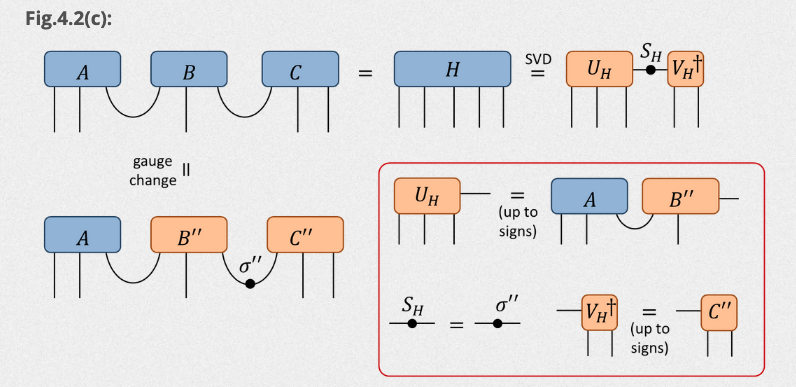

In [13]:
##### Ex4.2(c): equivalence of center of orthogonality and SVD
##### (continues from Ex4.2(b))
H = ncon([A,B,C],[[-1,-2,1],[1,-3,2],[2,-4,-5]])
utemp,stemp,vhtemp = LA.svd(H.reshape(d**3,d**2),full_matrices=False)
UH = utemp[:,:d].reshape(d,d,d,d)
SH = stemp[:d]
VH = vhtemp[:d,:].reshape(d,d,d)

# compare with previous tensors from orthonormal form 
ErrU = LA.norm(abs(UH) - abs(ncon([A,Bpp],[[-1,-2,1],[1,-3,-4]])))
ErrS = LA.norm(SH - Sig_pp) 
ErrV = LA.norm(abs(VH) - abs(Cpp))
# all three results should be vanishingly small!!!
print("|| UH - AB''|| = ", ErrU)
print("|| SH - σ''|| = ", ErrS)
print("||VH†-C|| = ", ErrV)

|| UH - AB''|| =  2.0633867863808163e-14
|| SH - σ''|| =  1.0173738755238984e-13
||VH†-C|| =  1.5578503717662848e-14



The identification between setting a center of orthogonality at a network link and the SVD of the network across the corresponding partition is a particularly useful result. Foremost, this provides a convenient means to optimally truncate indices within a network, as outlined in the theorem below.



================================================================================


**Theorem.4.2**: given a (loop-free) network of tensors {$A$, $B$, $C$ ...}, assume that we wish to truncate the link between a pair of tensors to a reduced dimension. Then the optimal truncation (as measured by the Frobenius norm between the initial and final networks) is given by first transforming the link in question into a center of orthogonality, and then truncating the smallest singular values from the corresponding link matrix. The truncation error is given as the square-root of the sum of the squares of the discarded singular values.  

================================================================================


The proof of this theorem follows trivially from the results for the SVD established in Tutorial 2. Similarly, other results from Tutorial 2 that were formulated in the context of the SVD of a matrix can likewise be exported to tensor networks. For instance, we can apply the same formalism developed in Section T2.4 to calculate the minimal dimension to which a link within a network can be truncated while maintaining a desired error threshold ε (i.e. the effective rank r of the link to accuracy ε). 



## T4.3: Canonical forms


As discussed in Tutorial 3, given a network of tensors {$A$, $B$, $C$ ...} we can manipulate the gauge degrees of freedom to set a chosen tensor $A$ as a center of orthogonality. However this does not fully fix the gauge degree freedom on any of the network links; the tensor $A$ will still remain a center of orthogonality under an unitary change of gauge (i.e. a change of gauge implemented by a unitary matrix and its hermitian conjugate).


In contrast, when setting a link as a center of orthogonality, the additional constraint that the link matrix is diagonal with positive elements in ascending order can completely fix the gauge freedom of this link (up to trivial changes of gauge only involving signs). In general, this is true if the elements of the link matrix are non-degenerate, otherwise there will remain a unitary gauge freedom within the degenerate subspace. This uniqueness property follows from the correspondence between the link-based center of orthogonality and the SVD, which is similarly unique. 


In this section, we describe a method for simultaneously setting every link of a network as a center of orthogonality, which also dictates a unique way to fix the gauge on each of the network links (i.e. such that no further non-trivial gauge changes can be made without destroying at least one of the centers of orthogonality). A network in this form, with every link simultaneously a center of orthogonality, is said to be in canonical form (or sometimes normal form).


The method for transforming a network into the canonical form is a straight-forward, since the direct orthogonalization approach can be used to change the gauge on a single link without affecting the rest of the network. Thus we can simply perform the appropriate gauge fixing manipulations, depicted in Fig.4.2(a) and Fig.4.2(b),  concurrently on all links. 

================================================================================


#### Procedure for transforming a network to canonical form: (see Fig.4.3(a))


- position a link matrix σ, initially set as the identity matrix, on each internal index.


- use the direct orthogonalization approach to independently set every link matrix σ as a center of orthogonality (i.e. by making a gauge change of the form X and X^(-1) on each link, where X is the principal square root of the corresponding branch density matrix ρ).


- make a unitary change of gauge on each link, with unitary matrices U and V given from the SVD of the link matrix σ' and their conjugates, such that the link matrix is transformed into a diagonal matrix with positive elements in ascending order.

================================================================================

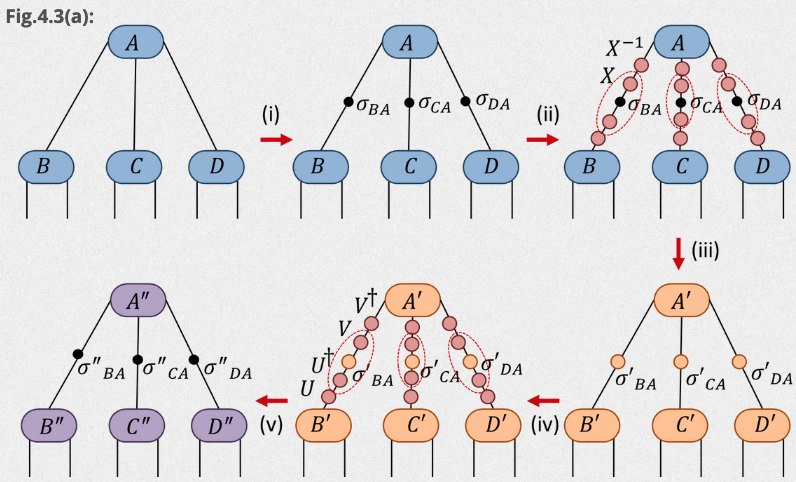


A network that is in canonical form, such that all link matrices are simultaneously centers of orthogonality, can be manipulated in a number of useful ways. In particular, we can easily fix any chosen tensor as a center of orthogonality, thus allowing us to recover the results from Tutorial 3. 

​

Consider, for example, the network in Fig.4.3(b), which is presumed to be in canonical form. (i) Assuming we wish to set some specified tensor $E$ as the center of orthogonality, we first label each index with an arrow that points towards tensor $E$. (ii) We then absorb into each tensor any link matrices σ that reside on its incoming indices. (iii) It follows from properties of the canonical form that all tensors in the resulting network are now isometric with respect to the partition between their incoming and outgoing tensor indices, similar to the network produced from the <u>**'pulling through'**</u> approach in Fig.3.3(c). Moreover, the specified tensor $E$ is a center of orthogonality in agreement with the established Def.3.3.

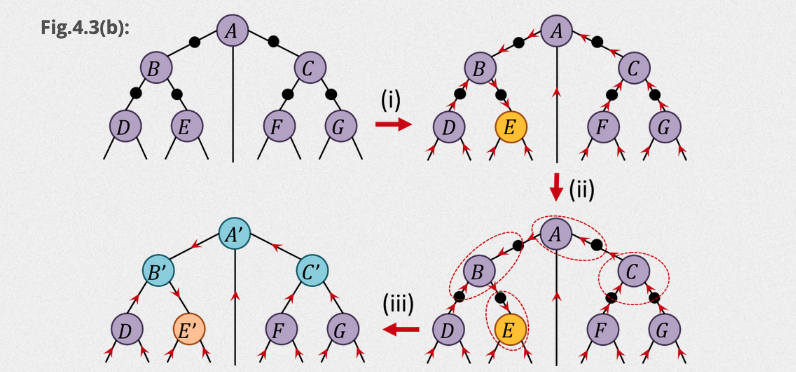


**Summary: Canonical Forms**

The canonical form results from a particular way of fixing the gauge degrees of freedom in a tensor network, and is useful as it organizes a network in such a way that important information is readily available. By setting a network in canonical form one can:

- optimally truncate any link to reduced dimension, simply discarding the smallest singular values from the corresponding link matrix, and easily understand the corresponding truncation error.

- essentially remove the gauge ambiguity from the network description, due to the uniqueness of the canonical form. 

- extract certain types information from network (such as expectation values) in a simplified manner, due to the cancellations that arise in networks containing isometric tensors. This aspect will be explored further in Tutorial 5.


**Outlook: Canonical Forms**

From this tutorial, you should have gained an understanding of how to accurately decompose a single tensor into a network of multiple tensors via a multi-stage decomposition. In addition you should also appreciate the significance of the canonical form for tensor networks and its relationship to the SVD. Finally you should also understand the method for transforming any loop-free network into canonical form. Proper use of the canonical form is important in many tensor network algorithms, such as the <u>**TEBD algorithm**</u>.

## Problem Set 4:

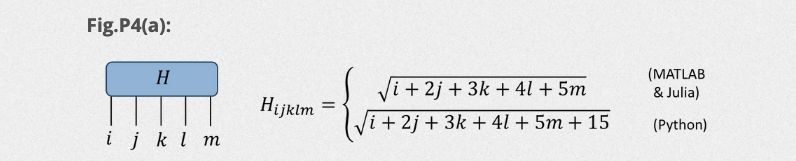

**Pb.4**: Consider the tensor H with the element-wise definition given in Fig.P4(a) (note that the definition has been modified to account for 1-based indexing of MATLAB/Julia versus 0-based indexing of python). 


**(a)** Generate tensor $H$ assuming all indices are dimension $d = 6$ and evaluate the norm ‖$H$‖. Define the normalized tensor $H_1$ = $H$ / ‖$H$‖

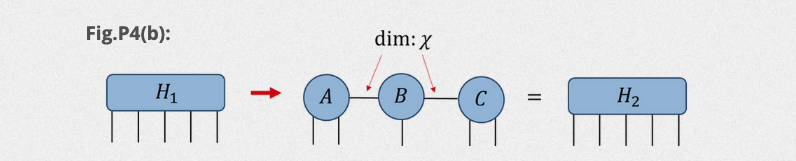


**(b)** Use a multi-stage decomposition to split H1 into a network of three tensors {$A$, $B$, $C$} while truncating to index dimension χ=6 as depicted in Fig.P4(b). Compute the truncation error ε = ‖$H_1 - H_2$‖, where $H_2$ is the tensor recovered from contracting {$A$, $B$, $C$}.

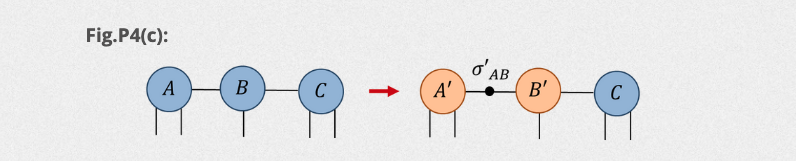

**(c)** Make the appropriate change of gauge such that the $A$-$B$ link becomes a center of orthogonality with a diagonal link matrix σ' as depicted in Fig.P4(d). What are the singular values in σ'? Check the validity if your gauge transformation by confirming that the singular values  σ' in match those obtained directly from the SVD of tensor $H_2$ across the equivalent partition.

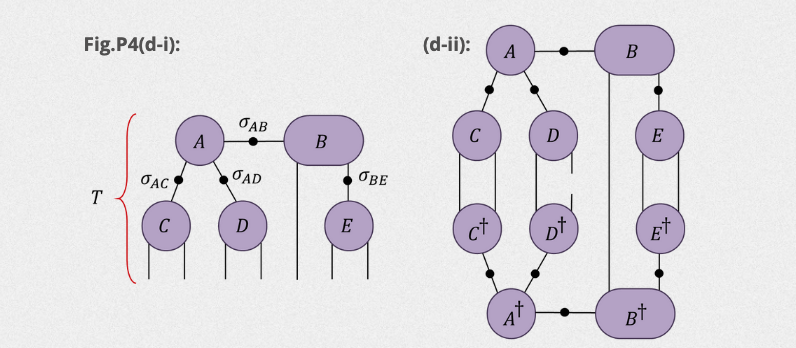

**(d)** Assume that the network $T$ in Fig.P4(d-i) is in canonical form. Depicted in (d-ii) is the partial tensor trace of $T$ with its conjugate network. Draw the simplified network that results from using properties of the canonical form to cancel tensors where-ever possible.    